In [2]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
import tphate, mds, phate, time
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Generate random autocorrelative data
def f(x, a, sigma):
    noisy = a*x + np.random.normal(0.0, sigma, size=x.shape)
    return noisy

features, samples=100,80
X = np.ones((features, samples))*np.arange(samples)
Ys = np.array([f(x, 2, 10) for x in X]).T # want samples x features input (timepoints by voxels)
Ys.shape

(80, 100)

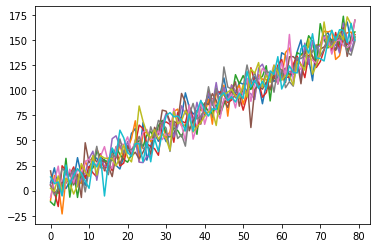

In [4]:
# plot data
_=plt.plot(Ys[:,::10])

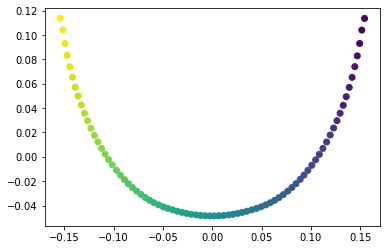

In [5]:
# Embed with tphate
tphate_op = tphate.TPHATE(n_jobs=-1, verbose=0, t=5, 
                          mds='metric', mds_solver='sgd', smooth_window=4)
embedding = tphate_op.fit_transform(Ys)
plt.scatter(embedding[:,0], embedding[:,1], c=np.arange(80))

In [6]:
tphate_op.dropoff

30

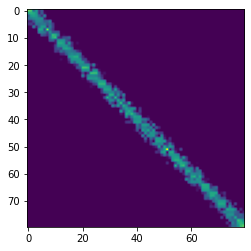

In [7]:
# Plot the PHATE diffusion operator
plt.imshow(tphate_op.phate_diffop)

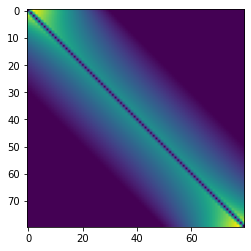

In [8]:
# plot the autocorrelation kernel
plt.imshow(tphate_op.autocorr_op)

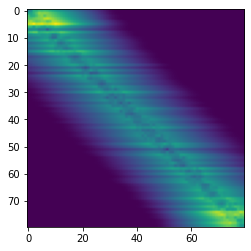

In [9]:
# Plot the combined TPHATE diffusion op
plt.imshow(tphate_op.diff_op)

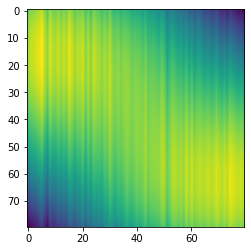

In [10]:
plt.imshow(tphate_op._diff_potential)

In [11]:
## Functions from before packaging it up -- just to double check .

def generate_fixed_autocorrelation_view(data, smooth_window=1):
    """ 
    Generates a diffusion operator based on the calculated autocorrelation function 
    of the input data (as smoothed over smooth_window).

    Parameters:
    data: numpy array of [n_timepoints, n_voxels]
    smooth_window: int, used for convolving the autocorrelation function in a rolling avg

    Output:
    M : numpy array of [n_timepoints, n_timepoints] symmetric matrix of row-normalized 
    fixed autocorrelation function
    """
    A_vox = np.empty_like(data) # placeholder for the autocorr functions of each voxel
    n_timepoints, n_voxels = data.shape

    # compute autocorr function independently for each voxel, then average over voxels 
    # (more stable than the reverse)
    for v in range(n_voxels):
        x = data[:, v]
        A_vox[:, v] = sm.tsa.acf(x, fft=False, nlags=len(x)-1) # calculate all possible lags 
    A_avg = np.mean(A_vox, axis=1)
    y = np.convolve(A_avg, np.ones(smooth_window), 'same') / smooth_window # rolling average
    # get the first point at which the rolling avg drops below zero; consider this the end of the function
    dropoff = np.where(y < 0)[0][0] 

    M = np.zeros((n_timepoints, n_timepoints))
    for i in np.arange(n_timepoints):
        for j in np.arange(n_timepoints):
            if abs(i-j) < dropoff and i != j:
                M[i, j] = y[abs(i-j)]
                M[j, i] = y[abs(i-j)]
    # row normalize
    for row in M:
        if np.sum(row) == 0: # this should never be true
            continue
        row[:] /= np.sum(row)
    return M

def embed_oldtphate(data):
    phate_op=phate.PHATE(verbose=0).fit(data)
    Top=generate_fixed_autocorrelation_view(data)
    P = np.matmul(phate_op.diff_op.T, Top)
    K = np.linalg.matrix_power(P, 5)
    K = np.log(K + 1e-7)
    K = np.nan_to_num(K, nan=0.0).T
    embedding = mds.embed_MDS(K, ndim=2, how='metric', 
                              n_jobs=-1, solver='sgd')
    return embedding,K,Top

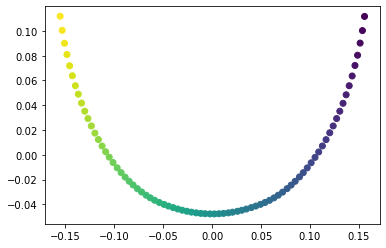

In [12]:
embd,K,Top=embed_oldtphate(Ys)
plt.scatter(embd[:,0], embd[:,1], c=np.arange(embd.shape[0]))

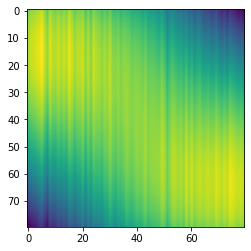

In [13]:
plt.imshow(K) # diffusion potential

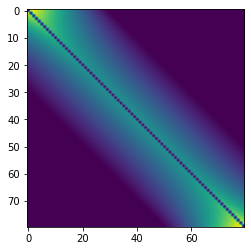

In [14]:
plt.imshow(Top) # ac kernel

In [15]:
ds = np.load('../src_data/sub-07_aud_early_sherlock_movie.npy')
#old_embd = np.load('../src_data/sub-04_early_visual_sherlock_movie_2dimension_embedding_TPHATE.npy')


In [16]:
tphate_op = tphate.TPHATE(n_jobs=-1, t=5, mds='metric', mds_solver='sgd',smooth_window=1)
embedding = tphate_op.fit_transform(ds)
#plt.scatter(embedding[:,0], embedding[:,1], c=np.arange(80))

Calculating TPHATE...
  Running PHATE on 1976 observations and 1018 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.77 seconds.
  Learning the autocorrelation function...
  Combining PHATE operator and autocorr operator
  Calculating diffusion potential...
  Calculated diffusion potential in 0.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.00 seconds.
Calculated TPHATE in 8.28 seconds.


In [17]:
import scprep

/gpfs/milgram/project/turk-browne/users/elb77/conda_envs/py3/lib/python3.6/site-packages/scprep/plot/tools.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  extent=[xmin, xmax, ymin, ymax],


<AxesSubplot:>

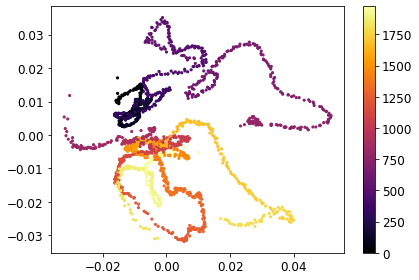

In [18]:
scprep.plot.scatter2d(embedding,c=np.arange(len(embedding)))

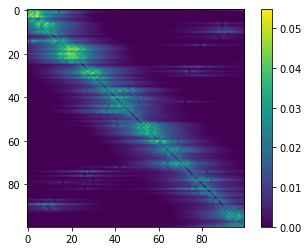

In [19]:
plt.imshow(tphate_op.diff_op[:100,:100])
plt.colorbar()

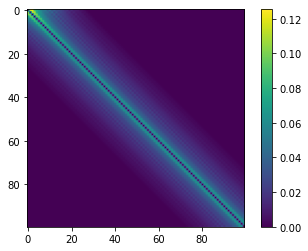

In [20]:
plt.imshow(tphate_op.autocorr_op[:100,:100])
plt.colorbar()

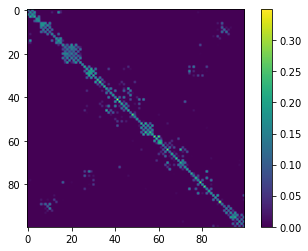

In [21]:
plt.imshow(tphate_op.phate_diffop[:100,:100])
plt.colorbar()

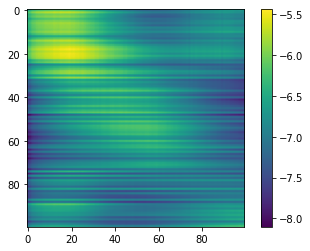

In [22]:
plt.imshow(tphate_op.diff_potential[:100,:100])
plt.colorbar()

In [23]:
tphate_op.dropoff

28